In [33]:
import sys
sys.path.insert(0, '/home/noah/Desktop/large_analysis/ca_analysis')
import numpy as np
from matplotlib.pyplot import *
import fileread as fr
import predefined as pd
import wave_ops as wo
import time

calibration=np.load('/home/noah/Desktop/large_analysis/ca_analysis/simulation_comparison/calibration.npy')
calibration=calibration.view(np.recarray)
def calibrate(energy_type,board,channel): 
    bdch=int(board*8+channel) 
    if bdch ==6: 
        m,b=1/calibration.slope[3],calibration.offset[3]
    elif bdch==11: 
        m,b=1/calibration.slope[0],calibration.offset[0]
    elif bdch==12: 
        m,b=1/calibration.slope[1],calibration.offset[1]
    elif bdch==35: 
        m,b=1/calibration.slope[2],calibration.offset[2]
    else: 
        m,b=0,0   
    return (energy_type-b)*m
vec_calibrate=np.vectorize(calibrate)



sim=fr.simulation(fname='/home/noah/Desktop/large_analysis/zeck_simulation/113Snaf.txt')
sim=pd.sim_comb_single_pixel(sim)
sim=sim.view(np.recarray)


Multipixel sum comparison

In [48]:

path='/home/noah/Desktop/large_analysis/ca_analysis/cur_data/'
run=131
data=fr.gen_output(path+'Run_'+str(run)+'-all.dat')[0]
data=data[pd.good_timestamps(data)]
data.sort(order='timestamp')


beg=time.time()
energy_type='energy'
twindow=500
multi=data.copy()
multi[energy_type]=vec_calibrate(multi[energy_type],multi['board'],multi['channel'])
#multi=multi[multi[energy_type]>15]
multi=multi[multi[energy_type]<450]
multi=multi[multi['t0']>600]
multi.sort(order='timestamp')
multi=multi[pd.lor(multi['pilediff']<twindow,multi['pileup']<2)]
multi=multi[pd.doubles(multi,energy_type)]
print(time.time()-beg)

cut=multi.copy()

i,j=0,0
while i<len(multi)-1 and j<len(multi)-1:
    j=i+1
    backscattering=multi['timestamp'][j]-multi['timestamp'][i] < twindow
    energy=multi[energy_type][i]
    while backscattering and j<len(multi)-1:
        energy+=multi[energy_type][j]
        multi[energy_type][j]=-10
        j+=1
        backscattering=multi['timestamp'][j]-multi['timestamp'][i] < twindow
    multi[energy_type][i]=energy
    i=j
print(time.time()-beg)

851.11527586
885.760617971


361.4


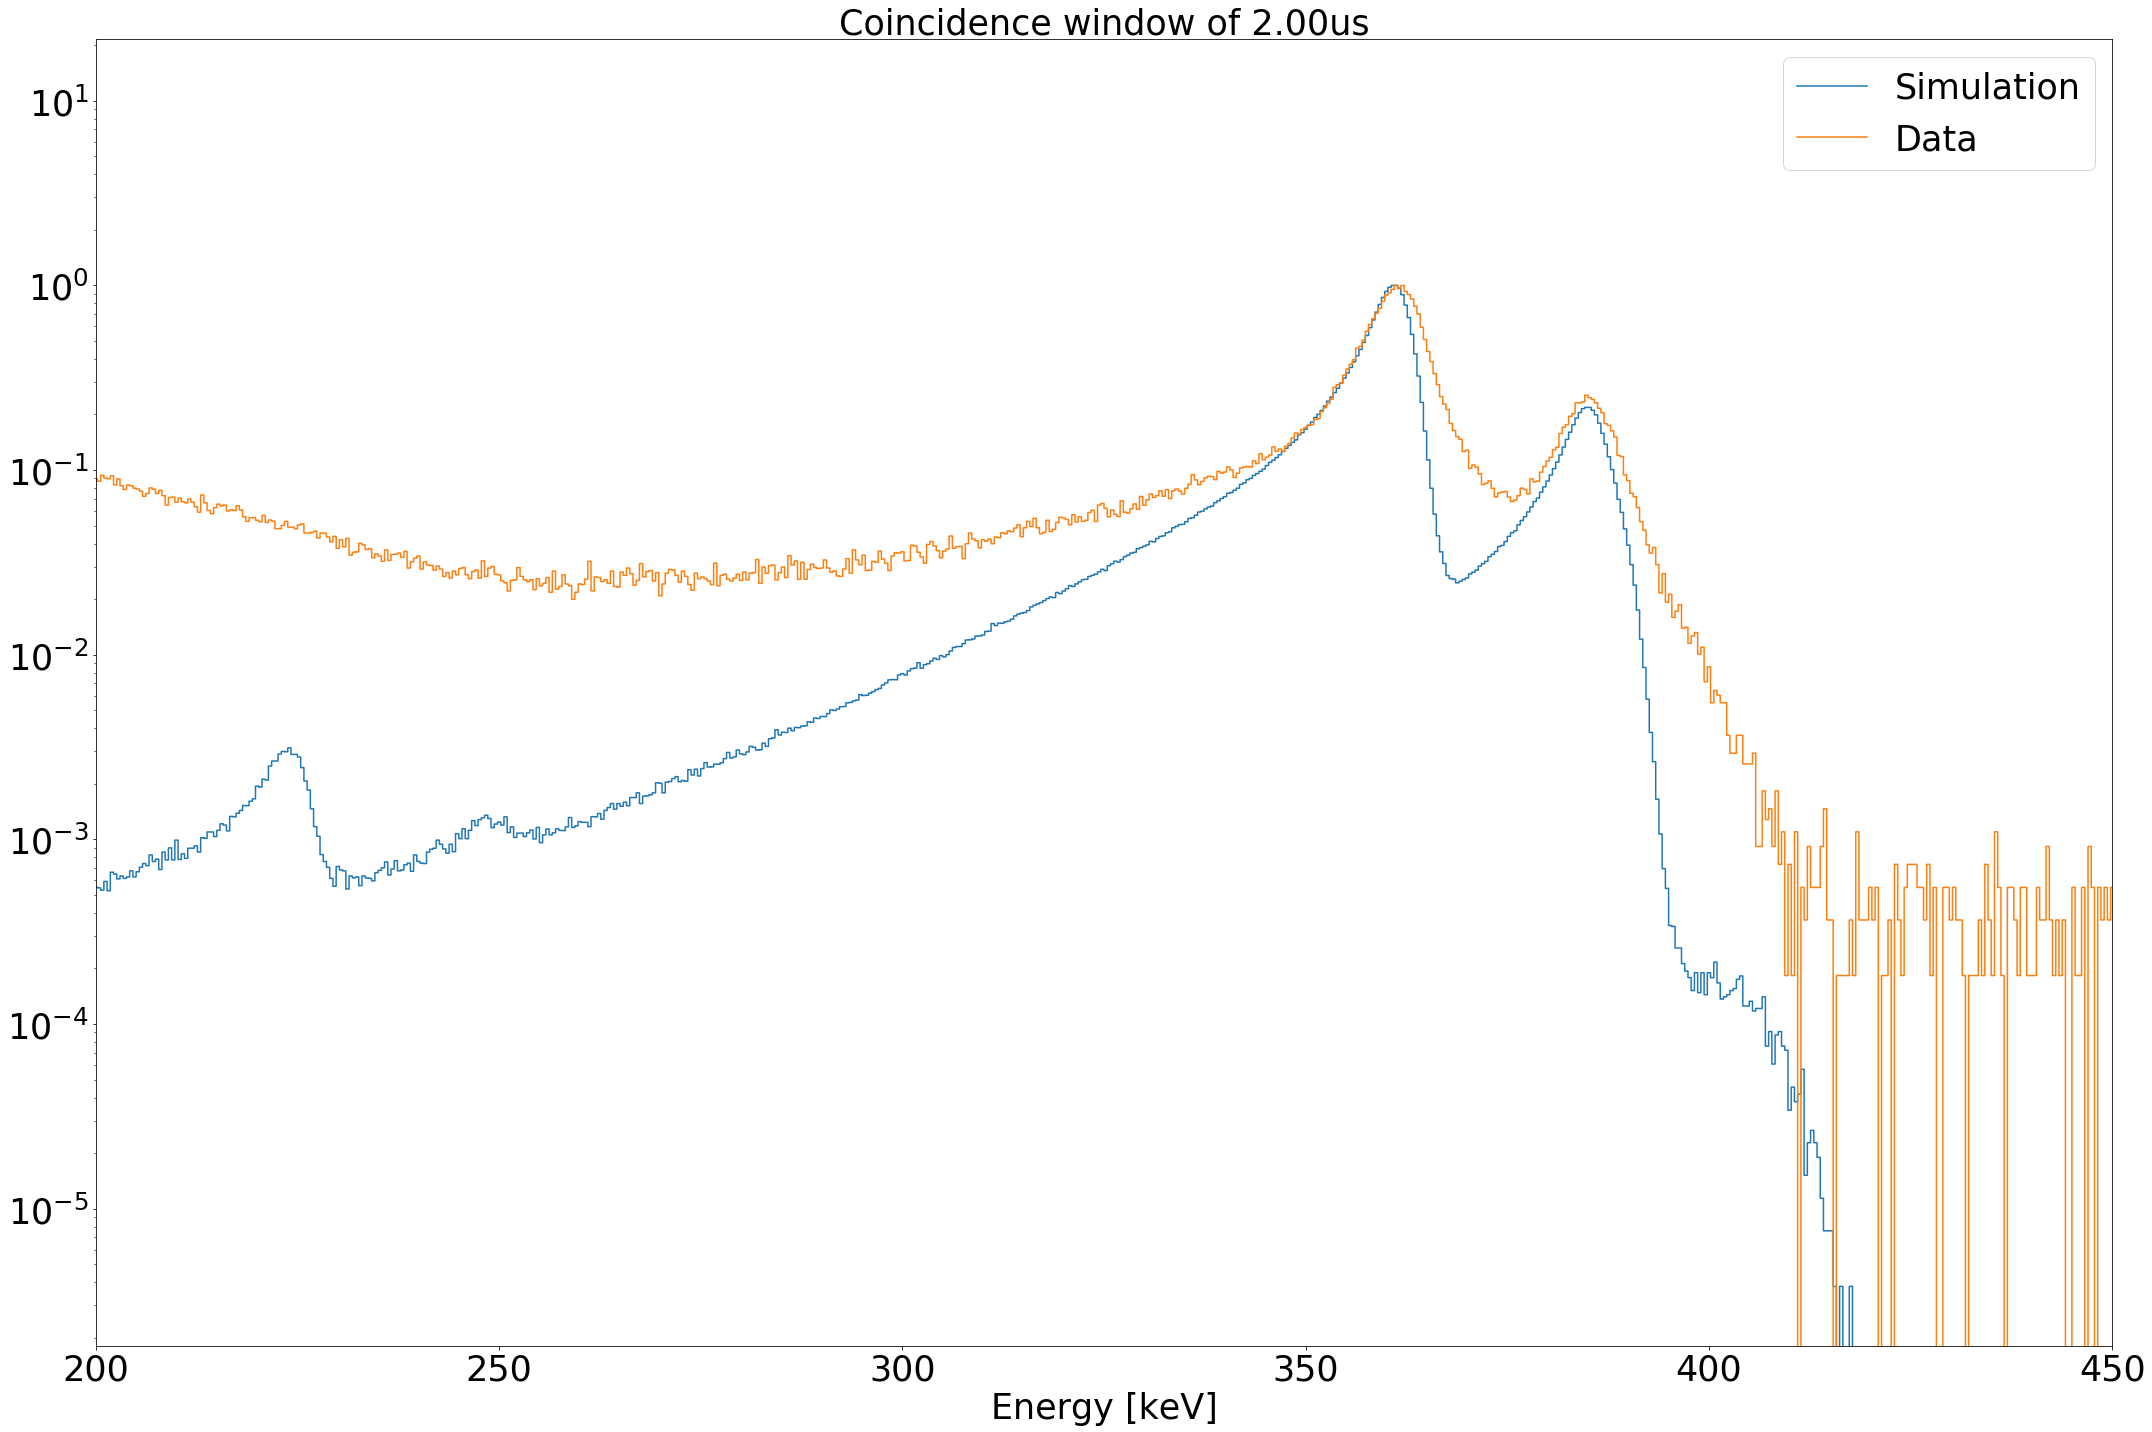

In [61]:
fs=35

savearray=True
loadarray=False
if savearray==True:
    np.save(file='/home/noah/Desktop/large_analysis/ca_analysis/multipixel/multi_'+\
            str(run)+'_window-'+str(twindow),arr=multi)       ####This is the array of interest
    np.save(file='/home/noah/Desktop/large_analysis/ca_analysis/multipixel/cut_'+\
            str(run)+'_window-'+str(twindow),arr=cut)
if loadarray==True:
    energy_type='energy'
    twindow=500
    multi=np.load('multi_'+str(run)+'_window-'+str(twindow)+'.npy')
    cut=np.load(file='cut_'+str(run)+'_window-'+str(twindow)+'.npy')
    

figure(figsize=(30,20))
bins=2000
datahist,bins=np.histogram(cut[energy_type],bins=bins,range=[0,800])
multihist,bins=np.histogram(multi[energy_type],bins=bins,range=[0,800])
simhist,bins=np.histogram(sim['energy'],bins=bins,range=[-20,800])
multihist=multihist.astype('float')
simhist=simhist.astype('float')
bins=pd.cbins(bins)
normbin=903
normE=bins[normbin]
print(bins[normbin])
#norm=[np.sum(datahist[bins>normE]),np.sum(simhist[bins>normE]),np.sum(multihist[bins>normE])]
norm=[0,simhist[normbin],multihist[normbin]]
cutbin=0
plot(bins,simhist/norm[1],ls='steps',label='Simulation')
#plot(bins,datahist/[norm[0]],ls='steps',label='Data no doubles no multipixel sum')
plot(bins[bins>cutbin],(multihist/norm[2])[bins>cutbin],ls='steps',label='Data')
#plot(bins,simhist/[norm[1]],label='Simulation')
tick_params(labelsize=fs)
scale='log'
yscale(scale)
legend(fontsize=fs)
title('Coincidence window of {:1.2f}us'.format(twindow*4e-3),fontsize=fs)
xlabel('Energy [keV]',fontsize=fs)
xlim(200,450)
tight_layout()
savefig('combined_sn113.pdf',format='pdf')
show()

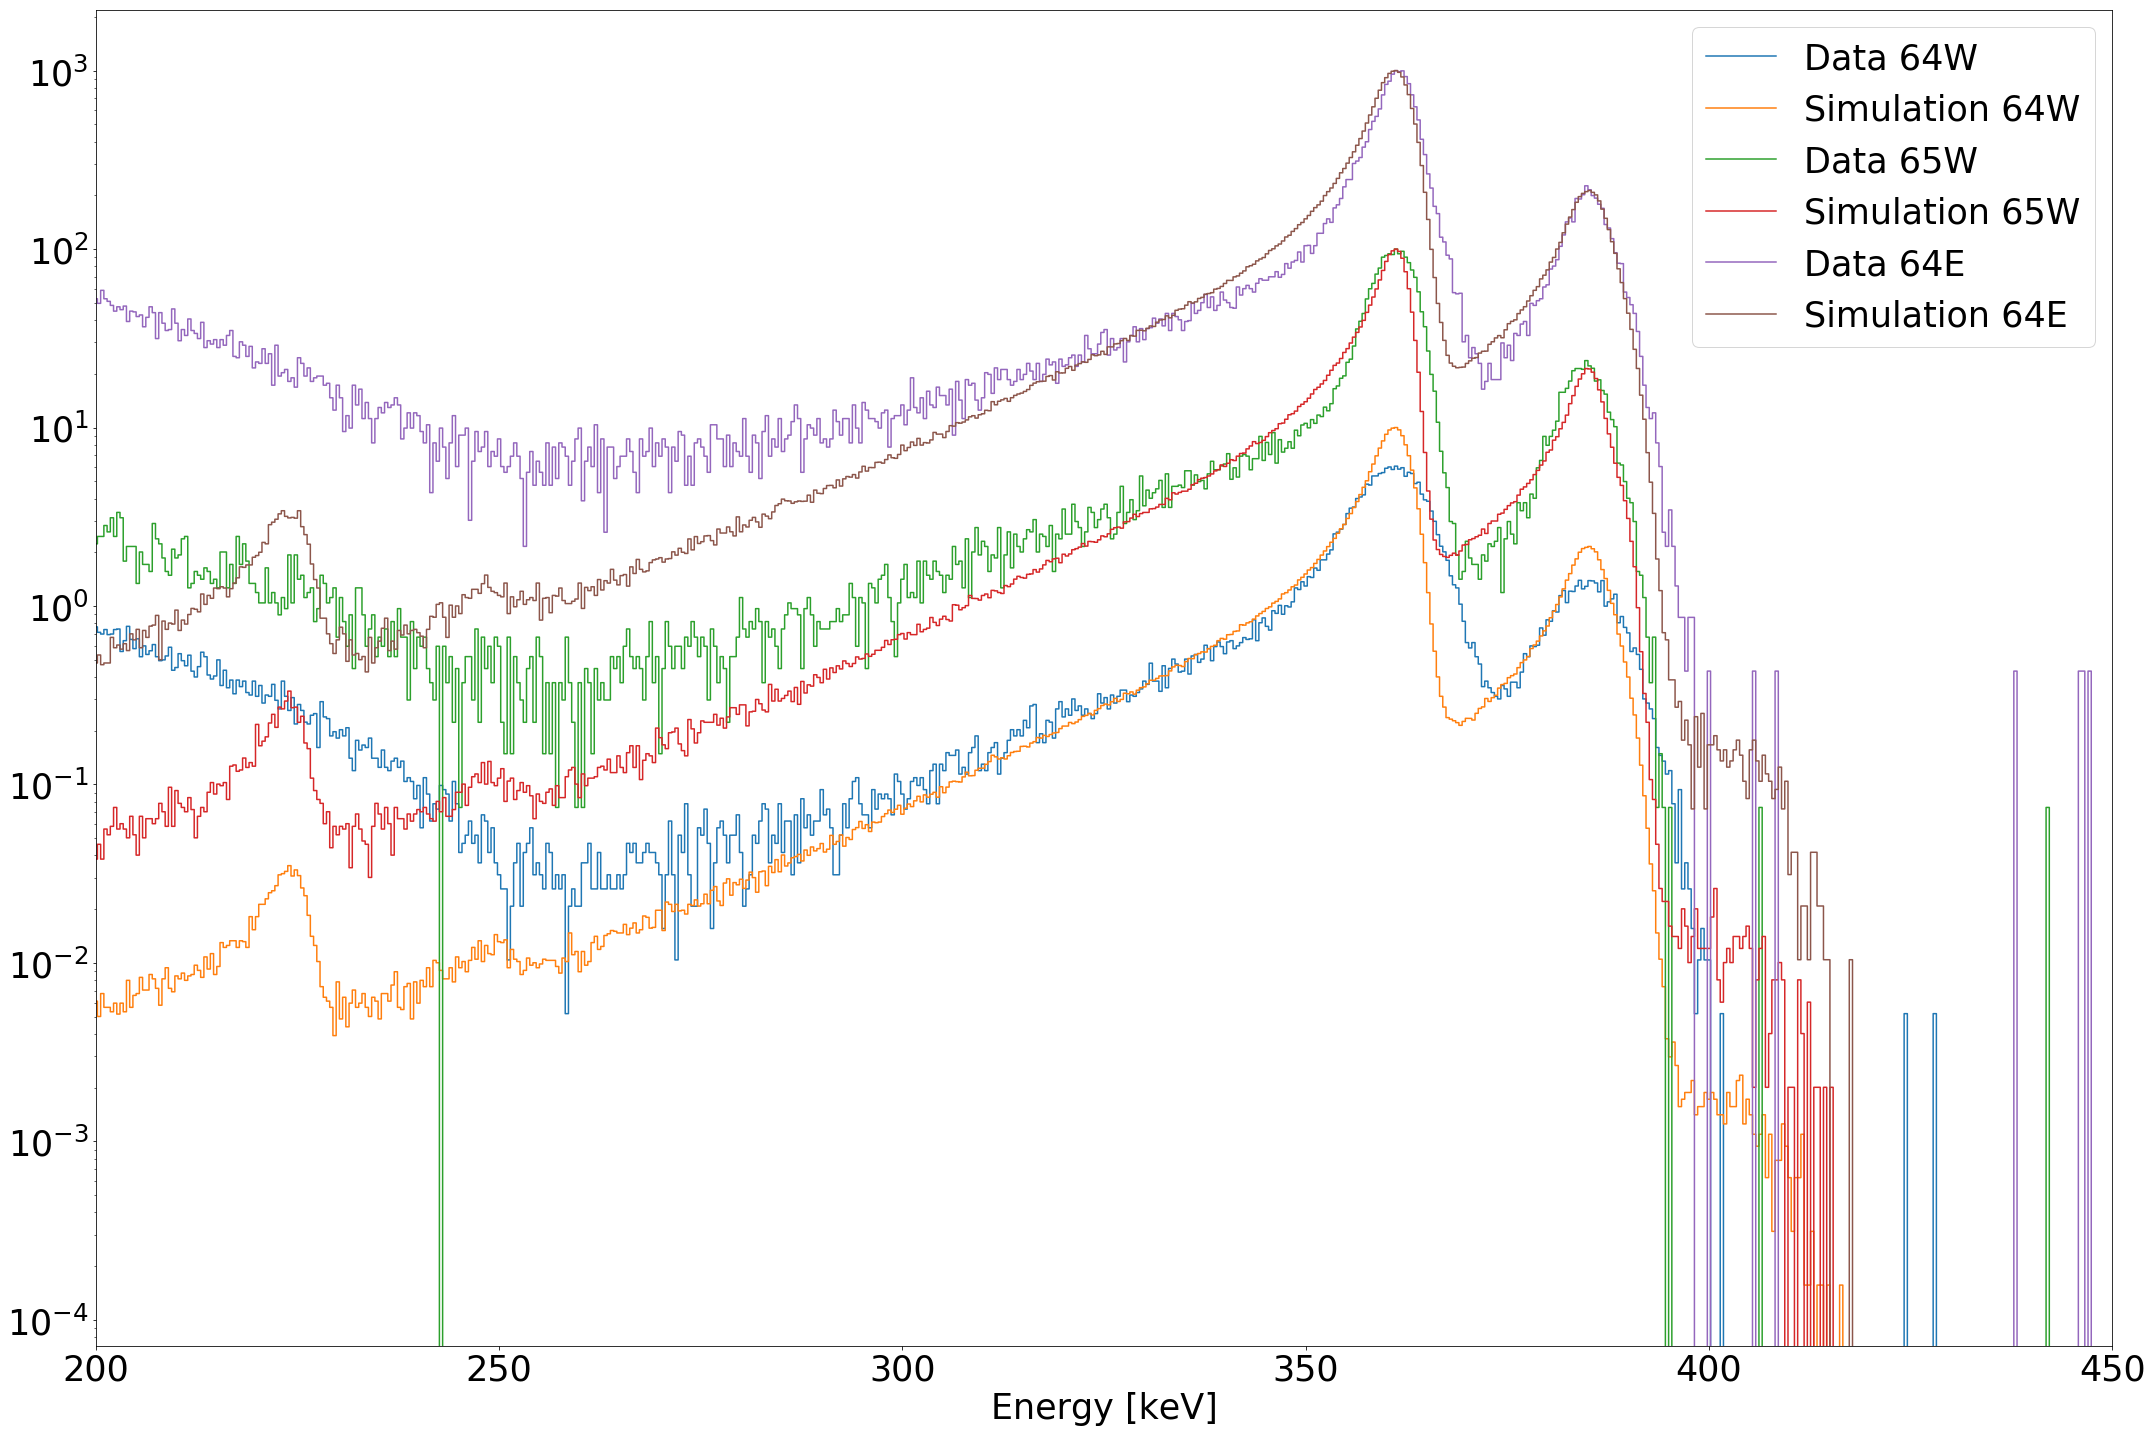

In [65]:
cut=pd.precuts(data)
cut=cut.view(np.recarray)
cut.energy=vec_calibrate(cut.energy,cut.board,cut.channel)
fig,ax1=subplots(figsize=(30,20))
i=1
bd,ch=4,3
dhist,bins=np.histogram(cut.energy[pd.land(cut.board==bd,cut.channel==ch)],bins=2000,range=[0,800])
simhist,bins=np.histogram(pd.sim_single_pixel(sim,bd,ch)['energy'],bins=2000,range=[0,800])
normdat=max(dhist)
normsim=max(simhist)
for pixel in (11,12,35):
    bd,ch=int(pixel/8),int(pixel%8)
    dhist,bins=np.histogram(cut.energy[pd.land(cut.board==bd,cut.channel==ch)],bins=2000,range=[0,800])
    simhist,bins=np.histogram(pd.sim_single_pixel(sim,bd,ch)['energy'],bins=2000,range=[0,800])
    dhist,simhist=dhist.astype('float'),simhist.astype('float')
    bins=pd.cbins(bins)
    ax1.plot(bins,dhist/np.max(dhist)*10**i,ls='steps',label='Data '+pd.pixel(bd,ch))
    ax1.plot(bins,simhist/np.max(simhist)*10**i,ls='steps',label='Simulation '+pd.pixel(bd,ch))
#    ax1.plot(bins,dhist/normdat,ls='steps',label='Data '+pd.pixel(bd,ch))
#    ax1.plot(bins,simhist/normsim,ls='steps',label='Simulation '+pd.pixel(bd,ch))
    i+=1
'''    ax1.tick_params(labelsize=fs)
    ax1.set_yscale('log')
    ax1.set_xlim(200,450)
    ax1.legend(fontsize=fs)
    ax1.set_xlabel('Energy [keV]',fontsize=fs)
    tight_layout()
    savefig('pixel_comp_sn113-'+pd.pixel(bd,ch)+'.pdf',format='pdf')
    cla()'''
ax1.tick_params(labelsize=fs)
ax1.set_yscale('log')
ax1.set_xlim(200,450)
ax1.legend(fontsize=fs)
ax1.set_xlabel('Energy [keV]',fontsize=fs)
tight_layout()
savefig('pixel_comp_sn113-all.pdf',format='pdf')
show()


In [64]:
print(cut[0])

(1, 0, 1, 3, 1348366L, 1428694L, -1, 1.3060516119003296, 21.09877586364746, 1, 1001, 314.2153015136719, 988, array([ -31.18980217,    2.68580365,   18.19107246,  362.1496582 ], dtype=float32), array([ 0.57142907,  0.82475132,  0.69760048,  2.21198964], dtype=float32), 23.2464542388916, 358.9779357910156)
